# CREDIT CARD FRAUD DETECTION
Hello everyone! In this notebook we are going to learn classifiers to predict fraud in transactions.

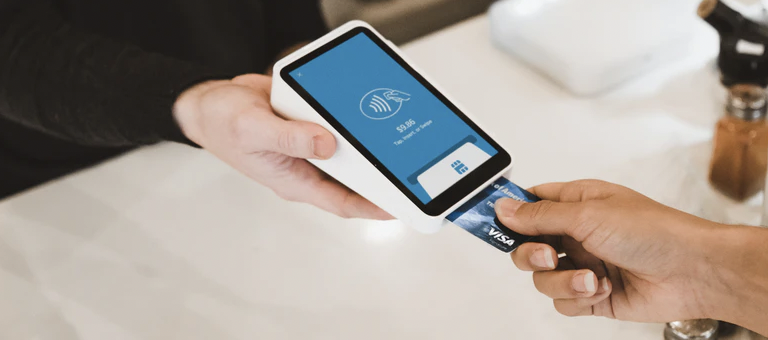

# 1. Import libraries
For classifying tasks we will use [sklearn](https://scikit-learn.org/stable/) library.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import RandomState
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

# CLASSIFIERS FOR TRAINING
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

# 2. Read data

In [2]:
df = pd.read_csv('../input/creditcardfraud/creditcard.csv', header = 0)

In [3]:
df.head(7) # look for first 7 rows

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0


In [4]:
df.shape # print size of dataframe

(284807, 31)

In [5]:
# convert from float64 to float32 to reduce memory size
df = df.astype({col: 'float32' for col in df.select_dtypes('float64').columns}) 
df = df.astype({col: 'int32' for col in df.select_dtypes('int64').columns}) 
# df.dtypes # print types of df

# 3. Visualize data
Firstly, lets see **how many records each class have**.

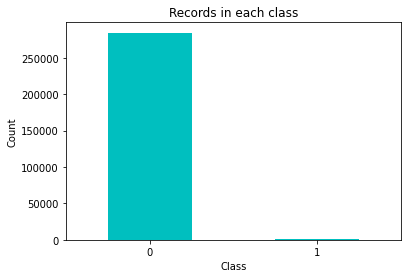

In [6]:
count_classes = df['Class'].value_counts()
plt.title("Records in each class")
count_classes.plot(kind='bar', color='c')
plt.xticks(rotation='horizontal')
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

After that we can check, **how many records were in each class during all the time**.

In [7]:
# all time was divided to 4 different intervals
bins = [0, max(df['Time'])/4, max(df['Time'])/2, 3*max(df['Time'])/4, max(df['Time'])] 
time_intervals = pd.cut(df['Time'], bins=bins)

In [8]:
# and then we group data by class
df_grouped2 = df.groupby(['Class', time_intervals]).size().reset_index(name='Count')
df_grouped2

,Class,Time,Count
0,0,"(0.0, 43198.0]",47249
1,0,"(43198.0, 86396.0]",97252
2,0,"(86396.0, 129594.0]",47342
3,0,"(129594.0, 172792.0]",92470
4,1,"(0.0, 43198.0]",146
5,1,"(43198.0, 86396.0]",135
6,1,"(86396.0, 129594.0]",96
7,1,"(129594.0, 172792.0]",115


After that, we can build **bar charts** for each class.

In [9]:
# creating masks
mask1 = df_grouped2['Class']==0
mask2 = df_grouped2['Class']==1

# applying masks
df_sliced1 = df_grouped2.loc[mask1]
df_sliced2 = df_grouped2.loc[mask2]

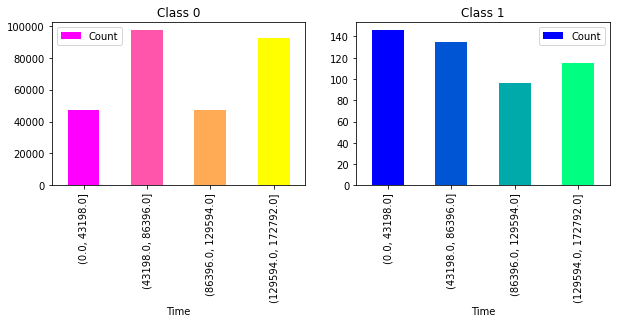

In [10]:
# creating plot with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

# setting colormaps for each subplot
color1 = plt.cm.spring(np.linspace(0, 1, len(df_sliced1['Time'].unique())))
color2 = plt.cm.winter(np.linspace(0, 1, len(df_sliced1['Time'].unique())))

# drawing plots
df_sliced1.plot(x='Time', y='Count', kind = 'bar', color=color1, title='Class 0', ax=axes[0])
df_sliced2.plot(x='Time', y='Count', kind = 'bar', color=color2, title='Class 1', ax=axes[1])

plt.show()

Also, we can **draw boxplots** to see, how the data is distributed.

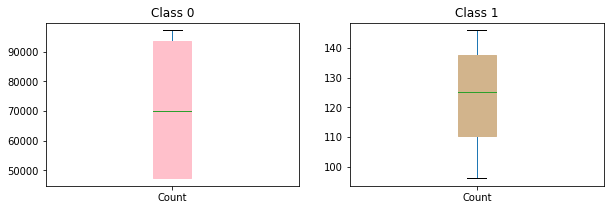

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

# titles for plots
axes[0].title.set_text('Class 0')
axes[1].title.set_text('Class 1')

# colors for drawing boxplots (used for 'patch_artist' below)
color1 = dict(boxes="pink")
color2 = dict(boxes="tan")

bplot1 = df_sliced1.boxplot(column=['Count'], grid=False, ax=axes[0], color=color1, patch_artist=True)
bplot2 = df_sliced2.boxplot(column=['Count'], grid=False, ax=axes[1], color=color2, patch_artist=True)

plt.show()

# 4. Normalize data
We will apply **min-max normalization** for our data.

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
normed = scaler.fit_transform(df)
df_normed = pd.DataFrame(data=normed, columns=df.columns)
df_normed.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,...,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0.0
1,0.000000,0.978542,0.770067,0.840298,0.271797,0.766120,0.262192,0.264875,0.786298,0.453981,...,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0.0
2,0.000006,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,...,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0.0
3,0.000006,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,...,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0.0
4,0.000012,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,...,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0.0


# 5. Split to train and val subsets
Here we're going to split data to train and validation subsets as **70% to 30%** respectively *(parameter frac=70)*.

In [13]:
rng = RandomState()

train = df_normed.sample(frac=0.7, random_state=rng)
val = df_normed.loc[~df_normed.index.isin(train.index)]

train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

In [14]:
print("♦ TRAIN SET:")
train.head(3)

♦ TRAIN SET:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.926380,0.955654,0.772956,0.805582,0.198372,0.784093,0.302463,0.262939,0.787050,0.492653,...,0.578778,0.551283,0.665312,0.475222,0.532999,0.529749,0.416080,0.316341,0.000564,0.0
1,0.672138,0.993111,0.767619,0.811020,0.258213,0.768046,0.254014,0.267339,0.782752,0.469777,...,0.559844,0.499326,0.668131,0.325320,0.577606,0.346099,0.415953,0.311721,0.000078,0.0
2,0.834865,0.948184,0.772669,0.903583,0.460509,0.764245,0.287484,0.260343,0.791329,0.441566,...,0.563425,0.553153,0.659258,0.346369,0.585306,0.527733,0.416953,0.310704,0.000590,0.0


In [15]:
print("♦ VALIDATION SET:")
val.head(3)

♦ VALIDATION SET:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,0.978542,0.770067,0.840298,0.271797,0.766120,0.262192,0.264875,0.786298,0.453981,...,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0.0
1,0.000006,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,...,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0.0
2,0.000023,0.979184,0.768746,0.838200,0.305241,0.767008,0.265762,0.265324,0.786257,0.478797,...,0.558776,0.497402,0.663145,0.277122,0.620014,0.383429,0.417148,0.313229,0.000194,0.0


# 6. Split dataset to input and output variables (x and y)
Here we can see, that we should predicit *'Class'* variable, so it will be our 'y' and another columns will represent 'x'.

In [16]:
# form 'x' and 'y' data
x_columns = df.columns[:-1]
y_column = df.columns[-1]

In [17]:
# create 'x' and 'y' data for train
x_raw_train = train[x_columns]
y_raw_train = train[y_column]

X_train = x_raw_train.copy()
Y_train = y_raw_train.copy()

In [18]:
# create 'x' and 'y' data for validation
x_raw_val = val[x_columns]
y_raw_val = val[y_column]

X_val = x_raw_val.copy()
Y_val = y_raw_val.copy()

# 7. Classification itself
Here we are going learn our classificators. 

In [19]:
# list of all classifiers whick will be used for our data
all_classifers = [
    KNeighborsClassifier(2),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()
]

In [20]:
# there we will store accuracies to build plots and for choosing the best classifier
all_acc = {}

♦ KNeighborsClassifier           = 0.9994499    loaded_model score =    0.9994499
♦ SVC                            = 0.9993095    loaded_model score =    0.9993095
♦ DecisionTreeClassifier         = 0.9989935    loaded_model score =    0.9989935
♦ RandomForestClassifier         = 0.9995201    loaded_model score =    0.9995201
♦ AdaBoostClassifier             = 0.9991924    loaded_model score =    0.9991924
♦ GradientBoostingClassifier     = 0.9990988    loaded_model score =    0.9990988
♦ GaussianNB                     = 0.9779851    loaded_model score =    0.9779851
♦ LinearDiscriminantAnalysis     = 0.9992744    loaded_model score =    0.9992744
♦ QuadraticDiscriminantAnalysis  = 0.973561     loaded_model score =     0.973561
♦ LogisticRegression             = 0.9989701    loaded_model score =    0.9989701


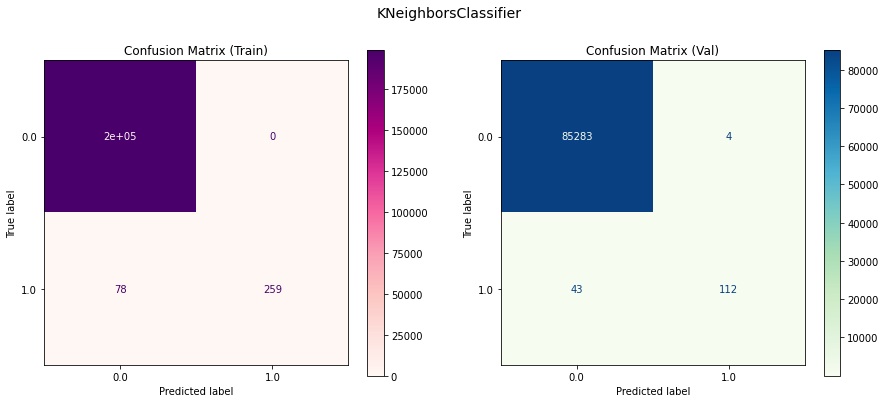

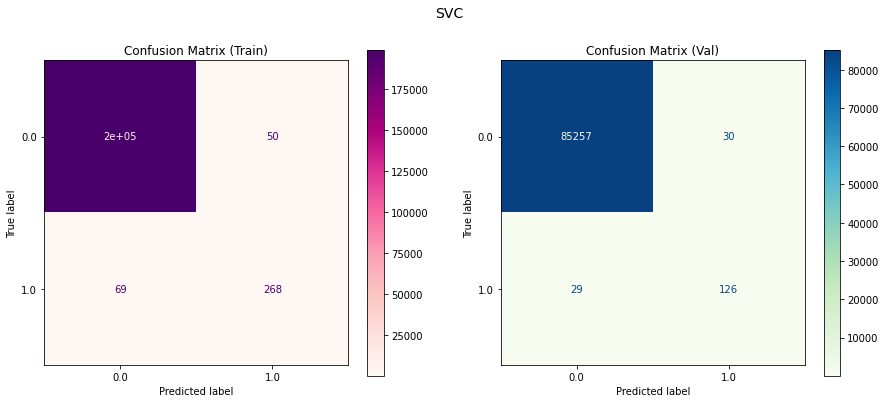

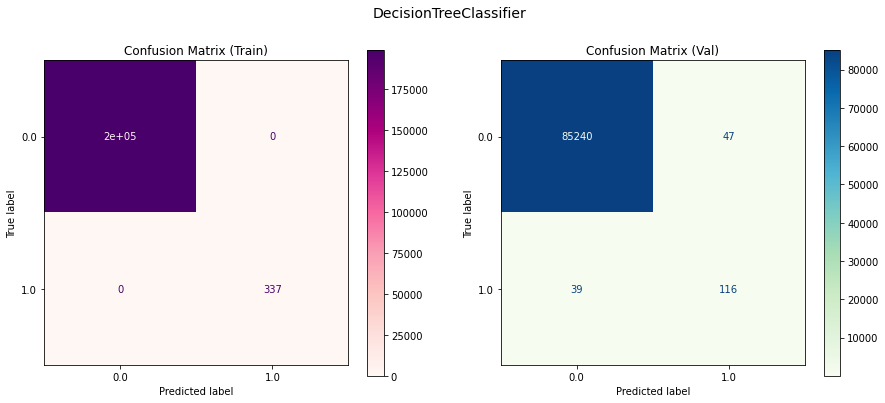

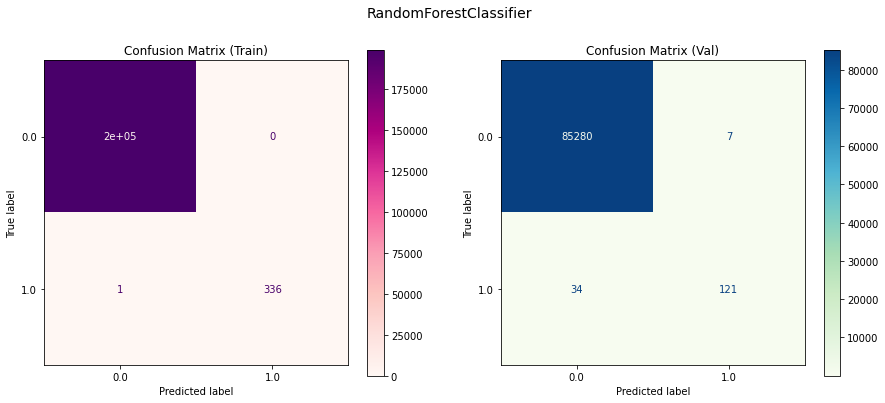

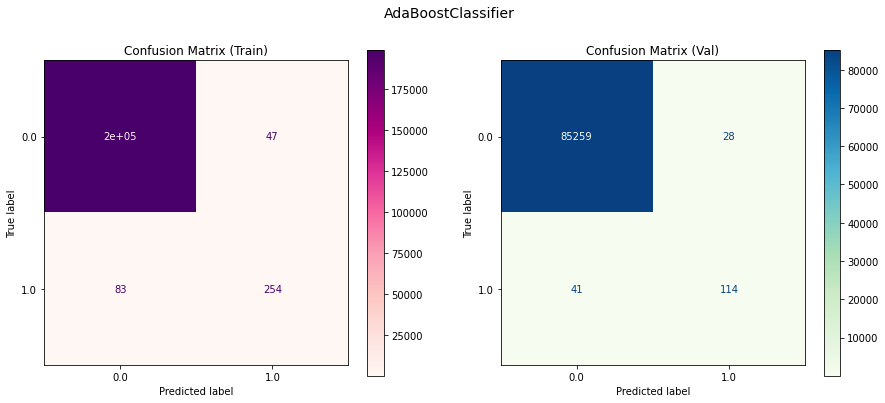

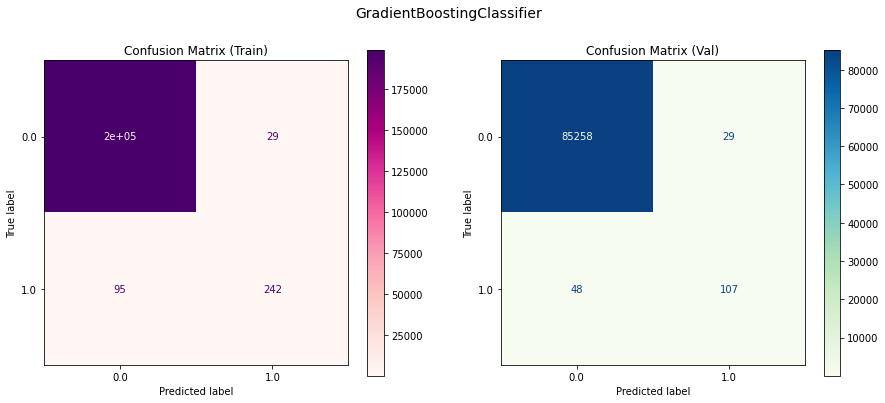

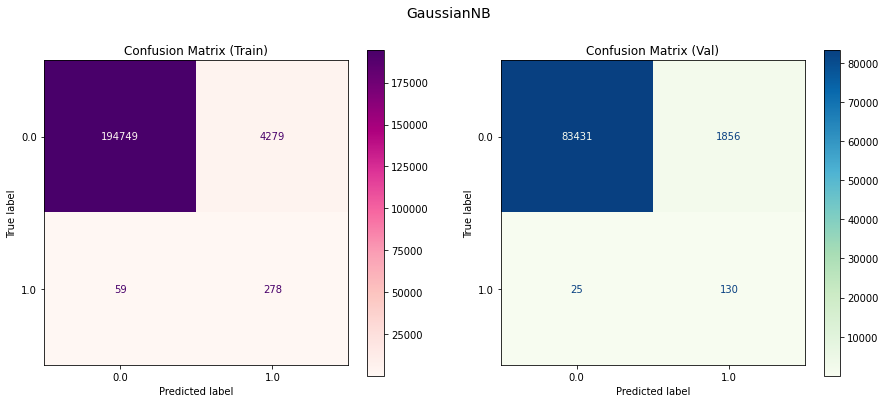

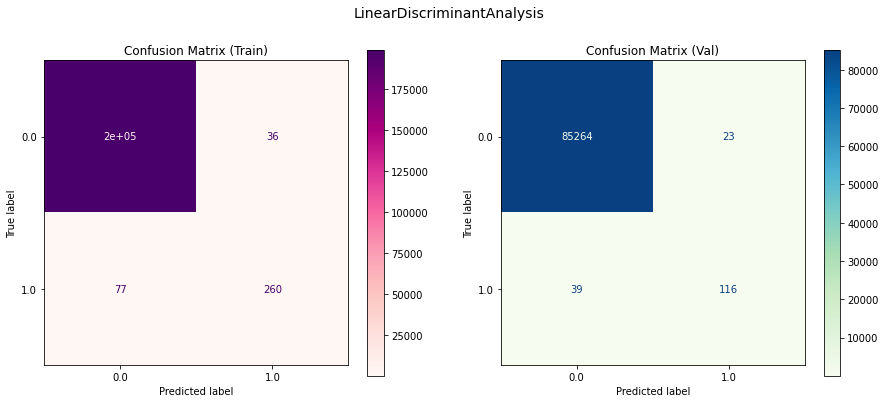

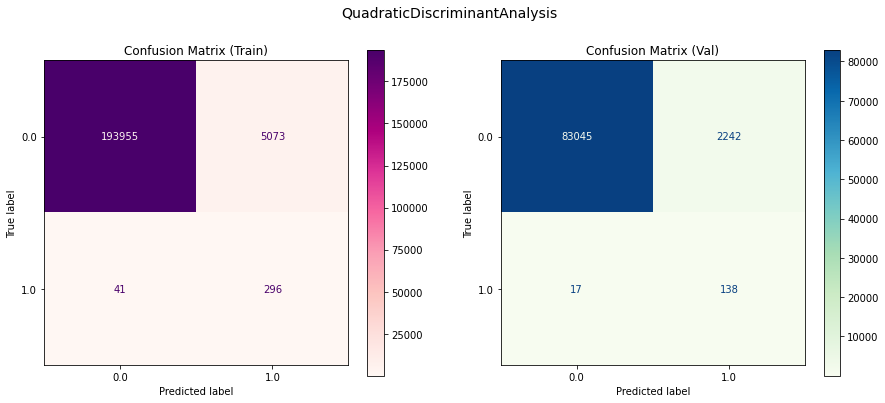

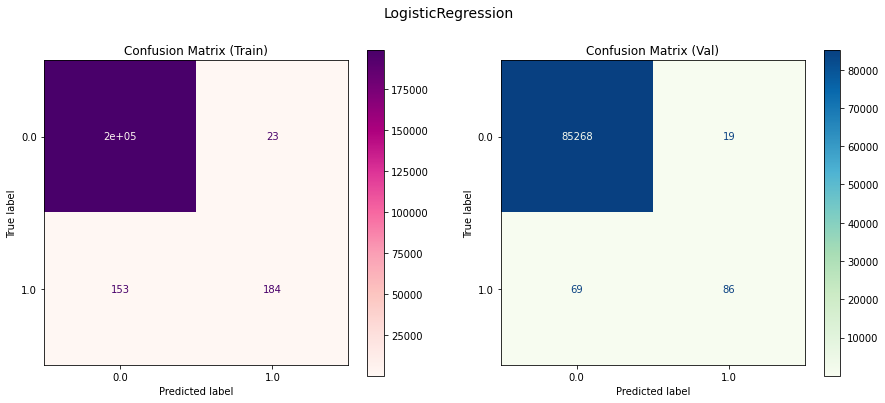

In [21]:
# learn all classifiers, write accuracy and save trained models in pickle-format

for classifier in all_classifers:
    
    # get the classifier name 
    classfier_name = classifier.__class__.__name__ 
    
    # train model
    model = classifier
    model.fit(X_train, Y_train)
    
    # validate model
    model_pred = model.predict(X_val)
    model_acc = accuracy_score(Y_val, model_pred)
    
    # calculate confusion matrix for train and val subsets
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    # titles for plots (1 common and 2 for subplots)
    plt.suptitle(classfier_name, fontsize=14)
    axes[0].title.set_text('Confusion Matrix (Train)')
    axes[1].title.set_text('Confusion Matrix (Val)')
    plot_confusion_matrix(model, X_train, Y_train, cmap=plt.cm.RdPu, ax=axes[0])
    plot_confusion_matrix(model, X_val, Y_val, cmap=plt.cm.GnBu, ax=axes[1])
    
    
    # save its accuracy
    all_acc[classfier_name] = model_acc
    
    # save model
    filename = classfier_name + '_model.pickle'
    pickle.dump(model, open(filename, 'wb'))  
    
    # load model
    loaded_model = pickle.load(open(filename, 'rb'))
    result = loaded_model.score(X_val, Y_val)     
    
    # print results
    print("♦ {:<30} = {:<12} {:>10} = {:>12}".format(classfier_name, round(model_acc, 7),
                                                   "loaded_model score", round(result, 7)))
    
    
    
plt.show() # show plots in the end 

After training, we can build **bar chart** to compare the training results and choose the best trained model with the biggest accuracy score.

In [25]:
# F1 score
from sklearn.metrics import classification_report

y_preds_rf = model.predict(X_val)
print(classification_report(y_raw_val, y_preds_rf))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85287
         1.0       0.82      0.55      0.66       155

    accuracy                           1.00     85442
   macro avg       0.91      0.78      0.83     85442
weighted avg       1.00      1.00      1.00     85442



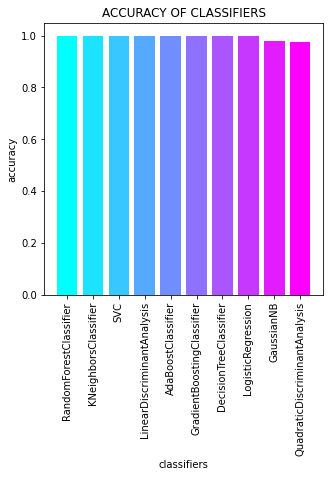

In [22]:
# sort accuracies from biggest to smallest
all_acc = dict(sorted(all_acc.items(), key=lambda item: item[1], reverse=True))

# get keys and values as parameters to build plot
keys = all_acc.keys()
values = all_acc.values()

# color map for bar chart
color = plt.cm.cool(np.linspace(0, 1, len(keys)))

# plot
plt.figure(figsize=(5,5))
plt.title('ACCURACY OF CLASSIFIERS')
plt.xlabel('classifiers')
plt.ylabel('accuracy')
plt.bar(keys, values, color=color)
plt.xticks(rotation = 'vertical')
plt.show()

# 8. Conclusion
Thank you for reading my new article! Hope, you liked it and it was interesting for you! There are some more my articles:

* [Neural Network for beginners with keras](https://www.kaggle.com/maricinnamon/neural-network-for-beginners-with-keras)
* [Fetal Health Classification for beginners sklearn](https://www.kaggle.com/maricinnamon/fetal-health-classification-for-beginners-sklearn)
* [Retail Trade Report Department Stores (LSTM)](https://www.kaggle.com/maricinnamon/retail-trade-report-department-stores-lstm)
* [Market Basket Analysis for beginners](https://www.kaggle.com/maricinnamon/market-basket-analysis-for-beginners)